In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from enzyme import *
from enzyme.src.main.run_simulation import run_simulation; import torch; from enzyme.src.network.Actor_Critic import Actor_Critic; import numpy as np
import matplotlib.pyplot as plt
from enzyme.scripts.plot_config import *
from enzyme.scripts.plotters import *

## Plotting

In [3]:
from enzyme.src.mouse_task.get_data import get_data
plotting_data = get_data(name = "large_100_batch_3")
batch_num = 10

loading data...


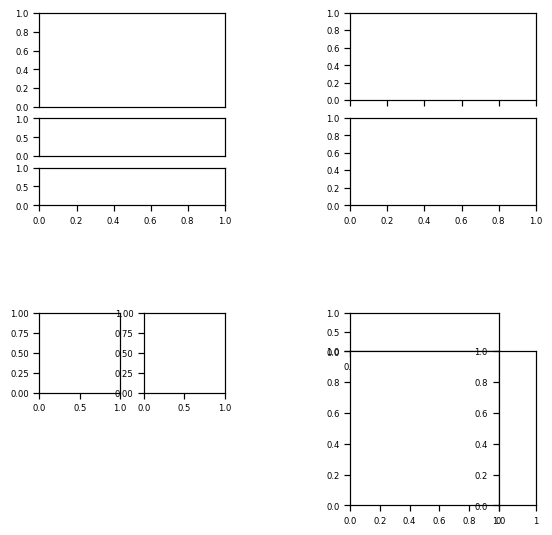

In [4]:



import matplotlib.cm as cm
from enzyme.src.helper import save_plot
from enzyme.src.helper import mystep
from matplotlib import ticker
from enzyme.colors import cmap;

PGOs = plotting_data["bayes_agent_and_trained_LSTM_representation"]["PGO_range"]
Cmap = cm.ScalarMappable(cmap=cmap, norm = cm.colors.Normalize(0, 1))
PGO_col = Cmap.to_rgba(np.linspace(0, 1, len(PGOs)))

PGO_N = len(PGOs)


SVG = False

lw_x = 1
lw_base = plt.rcParams['lines.linewidth']
lw_scale = 1.5

from enzyme.plot_helper import plotting_context
import seaborn as sns
ctx = plotting_context('paper', 
                       font_scale=.8,  # globally scale non-explicitly set fontsizes
                       scale=.7, # globally scale non-explicitly set line widths, markers, etc.
                       )  
sns.set_context(ctx)


fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH),)
# set constrained layout pads
fig.set_constrained_layout_pads(w_pad=0.2)

subfigs = fig.subfigures(2, 2, wspace=0.3, hspace=0.2,)


axd = {}
fig_ = subfigs[0, 0] 
axd_ = fig_.subplot_mosaic(mosaic='''
a
1
2
''',
height_ratios=[1, .4, .4],
)

axd.update(axd_)

fig_ = subfigs[0, 1]
axd_ = fig_.subplot_mosaic(mosaic=[['b1'], ['b2']], sharex=True, sharey=False)
axd.update(axd_)

fig_ = subfigs[1, 0]
axd_ = fig_.subplot_mosaic(mosaic=[['c1', 'c2',],
                                   ['d1', 'd1' ],
                                   ],  gridspec_kw=dict(wspace=0.3, hspace=0.4))
axd.update(axd_)

fig_ = subfigs[1, 1]
axd_ = fig_.subplot_mosaic(mosaic=[['e', '.'], 
                                   ['e1', 'e2']],
                                   width_ratios=[4, 1,], height_ratios=[1, 4,], 
                                   gridspec_kw=dict(wspace=0.0, hspace=0.0))
                           
axd.update(axd_)


ax_rates = axd['a']

ax_waits_n = axd['1']
ax_waits_b = axd['2']

ax_waits_b.sharex(ax_rates)
ax_waits_n.sharex(ax_rates)

ax_rates.xaxis.set_visible(False)
ax_waits_n.xaxis.set_visible(False)

ax_adapt_net = axd['b1']
ax_adapt_bayes = axd['b2']



ax_Q_timetrace1 = axd['c1']
ax_Q_timetrace2 = axd['c2']
ax_schematic = axd['d1']
ax_schematic.axis('off')

ax_Q_heatmap = axd['e1']
ax_x_hist = axd['e']
ax_y_hist = axd['e2']
# ax_x_hist.axis('off')
# ax_y_hist.axis('off')
# from matplotlib._layoutgrid import plot_children
# plot_children(fig)

In [5]:
batch_waits = batch_to_concat(plotting_data, "net_wait_from_last_nogo_vec", "trained_LSTM", batch_num)
batch_PGOs = batch_to_concat(plotting_data, "trial_PGO_vec", "trained_LSTM", batch_num)

In [6]:
ax = ax_waits_n
ax.cla()

metrics_LSTM = plot_t_wait_dist(ax, PGOs_data=batch_PGOs,
                 t_waits= batch_waits, 
                 marker=marker_nw, pad=-.02, 
                 bw_method=1/4,  # to deal with discrete data
                )

ax.set_ylabel('Network\n' + r'$P(\tau_w)$', rotation=0, labelpad=4, ha='right', va='center')

ax = ax_waits_b
ax.cla()
metrics_bayes = plot_t_wait_dist(ax, PGOs_data=plotting_data["bayes_agent_and_trained_LSTM_representation"]["trial_PGO_vec"] , 
                 t_waits=plotting_data["bayes_agent_and_trained_LSTM_representation"]["bayes_wait_from_last_nogo_vec"],
                 marker=marker_bayes, pad=+.02, 
                 bw_method=1/4, 
                 )
ax.set_ylabel('Bayes\n' + r'$P(\tau_w)$', rotation=0, labelpad=4, ha='right', va='center')

Text(0, 0.5, 'Bayes\n$P(\\tau_w)$')

In [7]:
n  = "trained_LSTM"
net_agents = [n if i < 1 else n + "_" + str(i) for i in range(batch_num)]
agents = net_agents + \
       ["bayes_agent_and_trained_LSTM_representation"]
agent_markers = ['o']*batch_num + ['*']
agent_lines = ['-']*batch_num + ['--']
agent_marker_size = [3]*batch_num + [7]
agent_line_alpha = [.15]*batch_num + [1]

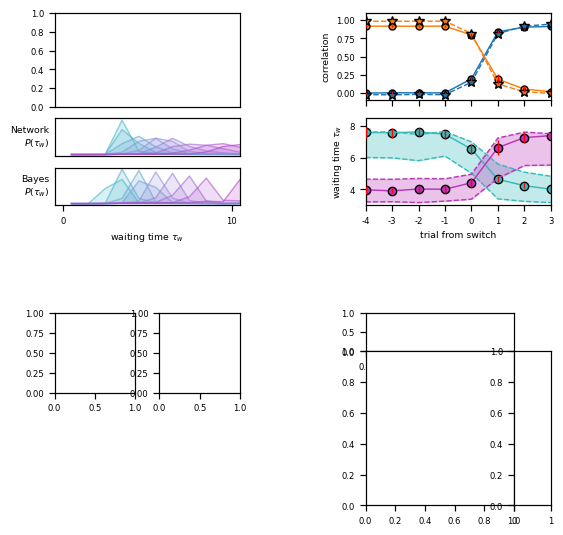

In [8]:
ax = ax_adapt_net  # Activate the first subplot
axb = ax_adapt_bayes
ax.cla()
axb.cla()
N_back = 4
xax = np.arange(-N_back, N_back)
""" corrs """
corrs = np.zeros((11, 2*N_back, 2))

all_nets_wait = []
all_nets_corr = []

for agent_i, (agent, marker, line, marker_size, line_alpha) in enumerate(zip(
    agents, agent_markers, agent_lines, agent_marker_size, agent_line_alpha)):
    data = plotting_data[agent]
    trial_vec, trial_PGO_vec = data["trial_vec"], data["trial_PGO_vec"]
    if agent_i < batch_num:
        wait_from_last_nogo_vec = data["net_wait_from_last_nogo_vec"] 
        all_nets_wait += [wait_from_last_nogo_vec]
    else:
        wait_from_last_nogo_vec = data['bayes_wait_from_last_nogo_vec']
            
    ctx_avg_waits = np.zeros(PGO_N)
    for p_i, p in enumerate(PGOs):
        inds = np.where(trial_PGO_vec == p)[0]
        ctx_avg_waits[p_i] = wait_from_last_nogo_vec[inds].mean()
    
    trials = np.arange(2*N_back)
    for i_tr in trials:

        prev_PGO_vec = np.roll(trial_PGO_vec, i_tr+1)
        cond = trial_vec == i_tr
        
        trial_vec_ = trial_vec[cond]
        trial_wait = wait_from_last_nogo_vec[np.where(cond)[0]-N_back]

        X = trial_wait
        X = X - X.mean(-1, keepdims = True)
        X_var = (X**2).sum(-1, keepdims = True)

        Y0 = trial_PGO_vec[cond]
        Y1 = prev_PGO_vec[cond]    

        """ corr with avg wait """
        Y0 = ctx_avg_waits[np.searchsorted(PGOs, Y0)]
        Y1 = ctx_avg_waits[np.searchsorted(PGOs, Y1)]
        """ corr with avg wait """
        
        Y0 = Y0 - Y0.mean(-1, keepdims = True)    
        Y0_var = (Y0**2).sum(-1, keepdims = True)
        Y1 = Y1 - Y1.mean(-1, keepdims = True)    
        Y1_var = (Y1**2).sum(-1, keepdims = True)
        
        var0 = X_var @ Y0_var.T
        var1 = X_var @ Y1_var.T
        
        var0 = var0.astype(float)       
        var1 = var1.astype(float)       
        corrs[agent_i, i_tr, 0] = (X @ Y0.T) / np.sqrt(var0)
        corrs[agent_i, i_tr, 1] = (X @ Y1.T) / np.sqrt(var1)
#    for c_i, c in enumerate(['C0', 'C1']):
#        if not agent in net_agents:
#            ax.plot(xax, corrs[agent_i,:,c_i], linestyle = line, marker = marker, mec = 'k', c = c,  alpha = line_alpha, zorder = 10)
#            ax.plot(xax, corrs[agent_i,:,c_i], marker = marker, zorder=  100, c = c, markersize = marker_size, mec = 'k', mew = .5,  linestyle='None')

# do the loop anew because only now the data has been filled
#for agent_i, (agent, marker, line, marker_size, line_alpha) in enumerate(zip(
#    agents, agent_markers, agent_lines, agent_marker_size, agent_line_alpha)):
#    if agent_i >= 1: break
#    for c_i, c in enumerate(['C0', 'C1']):
#        if agent in net_agents:
#            ax.plot(xax, corrs[:,:,c_i].mean(0), linestyle = line, c = c,  alpha = line_alpha, zorder = 10, mec = 'k', markersize = 7)
#            ax.errorbar(xax, corrs[:,:,c_i].mean(0), yerr=corrs[:, :, c_i].std(0), marker = marker, zorder= 100, c = 'r', markersize = marker_size, mec = 'k', mew = .5,  linestyle='None', ecolor='k')


for c_i, c in enumerate(['C0', 'C1']):
    mu = corrs[:-1,:,c_i].mean(0)
    std = corrs[:-1,:,c_i].std(0)
    ax.plot(xax, mu, '-o', c = c, markersize = 5, mec = 'k')
    ax.errorbar(xax, mu, yerr=std, marker=None, c = 'r', linestyle = 'None', zorder = 100, elinewidth= 1)

    ax.plot(xax, corrs[-1,:,c_i], '--*', c = c, markersize = 7, mec = 'k')
ax.set_ylabel(r'correlation')
# ax.set_xlabel(r'trial from switch')
ax.set_xlim([-N_back, N_back-1])
ax.set_ylim([-.1,1.1])

""" chunking PGOs """
low_chunk = [.3, .3]
high_chunk = [.7, .7]
waits_PGO_mean = np.zeros((batch_num + 1, 2*N_back, 2))
waits_PGO_std = np.zeros((2*N_back, 2))

chunks = [high_chunk, low_chunk]


for agent_i, (agent, marker) in enumerate(zip(
    agents, agent_markers)):
    data = plotting_data[agent]
    trials = np.arange(2*N_back)
    for i_tr in trials:
            act_inds = data["step_act_vec"] 
            trial_PGO_vec = data["step_PGO_vec"][act_inds]
            trial_vec = data["step_trial_vec"][act_inds]
            RT = data['step_RT_vec'][act_inds]
            
            trial_PGO_vec = np.roll(trial_PGO_vec, - N_back)
            prev_PGO_vec = np.roll(trial_PGO_vec, i_tr+1)
            trial_vec = np.roll(trial_vec, - N_back)
    
            for c_i, (prev_chunk, curr_chunk) in enumerate(zip(chunks, reversed(chunks))):
                prev_leq_geq = (prev_PGO_vec == prev_chunk[0]) | (prev_PGO_vec == prev_chunk[1])
                curr_leq_geq =  (trial_PGO_vec == curr_chunk[0]) | (trial_PGO_vec == curr_chunk[1])
                cond = curr_leq_geq & prev_leq_geq & (trial_vec == i_tr)
                inds = np.where(cond)[0]
                waits_PGO_mean[agent_i, i_tr, c_i] = np.mean(RT[inds])
                if agent_i == batch_num:
                    waits_PGO_std[i_tr, c_i] = data['step_thresh_RMS_vec'][act_inds][inds].mean()             
    
for p in [0,1]:
    c = cmap_cool(float(p))
    W = waits_PGO_mean[:, :, p]
    err = waits_PGO_std[:, p]
#    for b in range(batch_num):
#         axb.plot(xax, W[b], 'o', c = c, markersize = 3, mec = 'k', linestyle = 'None', mew = .5)
#         axb.plot(xax, W[b], '-', c = c, alpha = .3)
    axb.errorbar(xax, W[:batch_num].mean(0), yerr=W[:batch_num].std(0), marker=None, c = 'r', linestyle = 'None', zorder = 100, elinewidth= 1)
    axb.plot(xax, W[:batch_num].mean(0), '-o', c = c, alpha = 1, mec = 'k', markersize = 6)


#    axb.plot(xax, W[-1], '-', c = c)
    axb.fill_between(xax, W[-1] - err, W[-1] + err, color = c, alpha = .3)
    axb.plot(xax, W[-1] - err, '--', c = c, linewidth = 1)
    axb.plot(xax, W[-1] + err, '--', c = c, linewidth = 1)
    
    axb.set_ylabel(r'waiting time $\tau_w$')
axb.set_xlabel(r'trial from switch')

bot = 3#0#2
top = 8.5#14#12
axb.set_xticks(ticks = xax, labels = xax)
axb.margins(x=0.1, y = .3)
axb.set_ylim([bot, top])
axb.set_xlim([-N_back, N_back-1])
fig

In [9]:
# fig.savefig(PRJ_ROOT / 'talk.png', dpi=300)
# fig.savefig(PRJ_ROOT / 'talk.svg', )

In [10]:
#raise KeyboardInterrupt

In [11]:
ax = ax_rates
ax.cla()

from matplotlib.mlab import GaussianKDE
from enzyme.plot_helper import no_autoscale
#import enzyme.scripts.mice_data as mice
PGO_show_local = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
#PGO_show_local = PGO_show

x_MU, x_STD, x_batch = batch_to_MU_STD(plotting_data, "analytical_rew_rate_points_x_axis", "trained_LSTM", batch_num)
y_MU, y_STD, y_batch = batch_to_MU_STD(plotting_data, "analytical_rew_rate_points_y_axis", "trained_LSTM", batch_num)

In [12]:
ax.cla()
for p_, PGO in enumerate(PGO_show_local):
    c_PGO = cmap_cool(PGO)
    p = np.argmin(np.abs(PGOs - PGO))
    alph = 1
    mfc = (c_PGO[0], c_PGO[1], c_PGO[2], alph)
    metrics_LSTM_ = metrics_LSTM[PGO]
#    for a in range(batch_num):
#        ax.plot(x_batch[a, p], y_batch[a, p], markersize = 2.5, mfc=mfc,
#            marker = marker_nw, mec='k', zorder = -2, mew = .5)
    ax.plot(x_MU, y_MU, markersize = 4, mfc=mfc, marker = marker_nw, mec='k', zorder = -2, mew = 1, linestyle = 'None')
    ax.errorbar(x_MU, y_MU, xerr=x_STD, yerr = y_STD, zorder=-1, marker = None, ls="none", c = 'r', elinewidth= .5)
    
    metrics_bayes_ = metrics_bayes[PGO]
    x = plotting_data["bayes_agent_and_trained_LSTM_representation"]["analytical_rew_rate_points_x_axis"][p] 
    y = plotting_data["bayes_agent_and_trained_LSTM_representation"]["analytical_rew_rate_points_y_axis"][p] 
    ax.errorbar(x, y, xerr=0*np.array([metrics_bayes_.std_l, metrics_bayes_.std_r])[:, None],
                zorder=-1,markersize = 7, mfc=mfc,
                marker = marker_bayes, ls="none", mec='k', mew = .5)

ax.margins(y=.9)
ax.set_ylim([.022, .04])#.038])
# JB: would not do a legend, we can do that in the caption
# ax.legend(["optimality", "network", "bayes"],   prop={'size': 6})

with no_autoscale(ax):
    for p_, PGO in enumerate(PGO_show_local):
        c_PGO = cmap_cool(PGO)
        p = np.argmin(np.abs(PGOs - PGO))
        x = plotting_data["bayes_agent_and_trained_LSTM_representation"]["analytical_rew_rate_curves_x_axis"]
        y = plotting_data["bayes_agent_and_trained_LSTM_representation"]["analytical_rew_rate_curves_y_axis"][p]
        ax.plot(x, y, color=c_PGO, zorder=-3)
ax.set_xlim(1, 15)
ax.autoscale_view()
ax.set_xlabel(r"waiting time $\tau_w$")
ax.set_ylabel(r"$r_t$")


Text(-10.483695652173912, 0.5, '$r_t$')

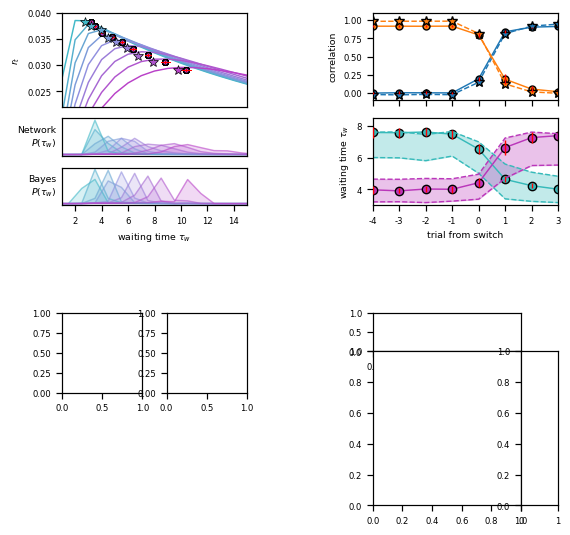

In [13]:
ax_rates.xaxis.set_visible(False)
#ax_waits_n.xaxis.set_visible(False)

fig

In [14]:
from enzyme.scripts.plotters import plot_heatmap_and_dists
name = "trained_LSTM"
bayes_DV_at_act, bayes_at_act_PGO, bayes_DV_pre_act, bayes_pre_act_PGO, bayes_DV_all, PGO_flat =\
    plot_heatmap_and_dists(plotting_data[name], ax_Q_heatmap, ax_x_hist, ax_y_hist,
    batch = True, agent_name = name, agent_num = batch_num, all_data = plotting_data, return_bayes_DV= True)

[INFO] [2025-02-04 15:01:15] in enzyme.scripts.plotters: collecting variables
[INFO] [2025-02-04 15:01:17] in enzyme.scripts.plotters: getting heatmaps
[INFO] [2025-02-04 15:01:20] in enzyme.scripts.plotters: plotting heatmaps
[INFO] [2025-02-04 15:01:20] in enzyme.scripts.plotters: getting regression
[INFO] [2025-02-04 15:01:20] in enzyme.scripts.plotters: getting histograms
[INFO] [2025-02-04 15:01:20] in enzyme.scripts.plotters: plotting histograms


In [15]:
from matplotlib.lines import Line2D
agent = plotting_data["trained_LSTM"]
flow_dist_from_opt_mus, _, _ = batch_to_MU_STD(plotting_data, "bayes_DV_mu", "trained_LSTM", batch_num)
flow_belief_RMS_mus, _, _ = batch_to_MU_STD(plotting_data, "bayes_DV_RMS", "trained_LSTM", batch_num)
#net_dist_from_opt_mus, _, _ = batch_to_MU_STD(plotting_data, "net_DV_mu", "trained_LSTM", batch_num)
#net_dist_from_opt_mus, _, _ = batch_to_MU_STD(plotting_data, "net_DV_est_mu", "trained_LSTM", batch_num)
net_dist_from_opt_mus, _, _ = batch_to_MU_STD(plotting_data, "QDIFF_mu", "trained_LSTM", batch_num)

ax1 = ax_Q_timetrace1
ax2 = ax_Q_timetrace2
ax1.cla()
ax2.cla()

T = len(flow_dist_from_opt_mus[0])//2 + 1
x = np.arange(-T, 0)

#for _, p in enumerate(PGO_show):
#    ip = np.where(PGO_show == p)[0][0]
#    ax.plot(x, net_dist_from_opt_mus[ip, :T], '-', color= 'k', linewidth = 2, zorder = -4)

for ip, p in enumerate(PGO_show):
#    lower = flow_dist_from_opt_mus[ip, :T] - flow_belief_RMS_mus[ip, :T]
#    upper = flow_dist_from_opt_mus[ip, :T] + flow_belief_RMS_mus[ip, :T]
#    ax.fill_between(x, lower, upper, alpha = .3, color=cmap_cool(p), zorder = -5)
    ax1.plot(x, flow_dist_from_opt_mus[ip, :T], '--', color=cmap_cool(p))
    ax2.plot(x, net_dist_from_opt_mus[ip, :T], '-', color=cmap_cool(p), label=rf"$\theta$ = {p:.1f}")
#    ax.plot(x, lower, linestyle = '--', color=cmap_cool(p), linewidth = 1, zorder = -5)
#    ax.plot(x, upper, linestyle = '--', color=cmap_cool(p), linewidth = 1, zorder = -5)

ax1.axhline(y = 0, c = 'r', linestyle = '--')
ax1.set_xlabel("time before action")
ax1.set_ylabel(r"distance from threshold $\delta(\mathcal{P}_t)$")
ax1.set_title('Bayes')
ax2.set_title('network')
ax2.axhline(y = 0, c = 'r', linestyle = '--')
ax2.set_xlabel("time before action")
ax1.set_ylim(flow_dist_from_opt_mus.min()-.1, .1)
ax2.set_ylim(net_dist_from_opt_mus.min()-1, 1)
ax1.set_xlim(-15, None)
ax2.set_xlim(-15, None)
# ax2.set_ylabel("distance from threshold")
ax2.set_yticks([])

# legend dummy handles
#l_line = Line2D([0], [0], color='k', label='decoded from network')
#l_fill = Line2D([0], [0], color='k', linewidth=plt.rcParams['lines.linewidth']*5, alpha=.3, 
#                label='Bayesian belief')

#ax.legend(handles=[l_line, l_fill], loc='lower right', frameon=False, fontsize='x-small')




[]

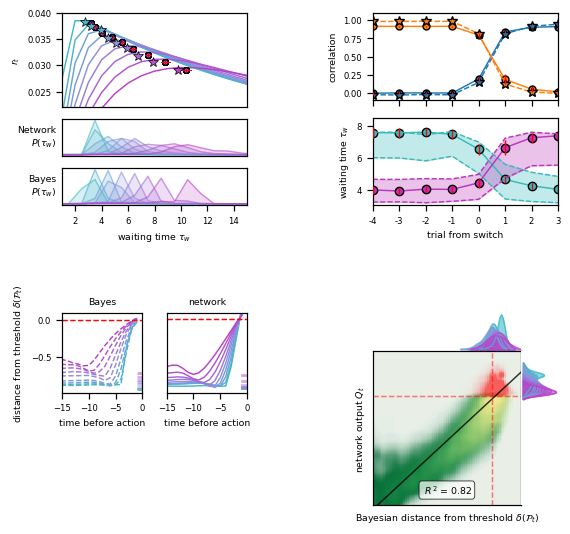

In [16]:
#net, net_SE, net_raw = batch_to_MU_STD(plotting_data, "QDIFF_mu_last_nog", "trained_LSTM", batch_num)
net, net_SE, net_raw = batch_to_MU_STD(plotting_data, "QDIFF_mul_ast_nog", "trained_LSTM", batch_num)
bayes, bayes_SE, bayes_raw = batch_to_MU_STD(plotting_data, "DV_mu_last_nog", "trained_LSTM", batch_num)
s = len(net[0])//2
xax = -np.arange(2)
for ip, p in enumerate(PGO_show):
    yax = np.ones(2)*bayes[ip, s]
    ax1.plot(xax, yax, linestyle= '--', linewidth = 2, color=cmap_cool(p), alpha = .5)
    yax = np.ones(2)*net[ip, s]
    ax2.plot(xax, yax, linestyle= '-', linewidth = 2, color=cmap_cool(p), alpha = .5)
fig


In [17]:
"""
net, net_SE, net_raw = batch_to_MU_STD(plotting_data, "QDIFF_mu_last_nog", "trained_LSTM", batch_num)
fig, ax = plt.subplots()
s = len(net[0]) // 2
ratio = net_raw[:, :, s].mean() / bayes_raw[:, :, s].mean()
ax.fill_between(PGO_show, (net[:, s]-net_SE[:,s]).T, (net[:, s]+net_SE[:,s]).T, color='C0', alpha = .5)
ax.plot(PGO_show, net[:, s].T, marker='o', markersize=5, c='C0', linewidth=.5, label=r"Network $\Delta$Q +/- STD")
ax.plot(PGO_show, bayes[:, s].T*ratio, linestyle = '--', marker='*', markersize=10, c='C0', linewidth=.5, label="Bayes DV (rescaled)")
plt.title(r" bayes DV and $\Delta$Q")
plt.xlabel(r"$\theta$")
plt.legend()
plt.show()

fig, ax = plt.subplots()
PM = 10
xax = np.arange(-PM, PM)
net, net_SE, net_raw = batch_to_MU_STD(plotting_data, "net_DV_mu_last_nog", "trained_LSTM", batch_num)

for p_i, p in enumerate(PGO_show):
    ax.plot(xax, net[p_i, s-PM:s+PM], color=cmap_cool(p), alpha = .5)
    ax.plot(xax, bayes[p_i, s-PM:s+PM], color=cmap_cool(p), linestyle = '--', linewidth=1)
plt.title("Bayes and decoded Distance to Threshold")
plt.xlabel("time from last nogo")
plt.legend()
plt.show()
"""


'\nnet, net_SE, net_raw = batch_to_MU_STD(plotting_data, "QDIFF_mu_last_nog", "trained_LSTM", batch_num)\nfig, ax = plt.subplots()\ns = len(net[0]) // 2\nratio = net_raw[:, :, s].mean() / bayes_raw[:, :, s].mean()\nax.fill_between(PGO_show, (net[:, s]-net_SE[:,s]).T, (net[:, s]+net_SE[:,s]).T, color=\'C0\', alpha = .5)\nax.plot(PGO_show, net[:, s].T, marker=\'o\', markersize=5, c=\'C0\', linewidth=.5, label=r"Network $\\Delta$Q +/- STD")\nax.plot(PGO_show, bayes[:, s].T*ratio, linestyle = \'--\', marker=\'*\', markersize=10, c=\'C0\', linewidth=.5, label="Bayes DV (rescaled)")\nplt.title(r" bayes DV and $\\Delta$Q")\nplt.xlabel(r"$\theta$")\nplt.legend()\nplt.show()\n\nfig, ax = plt.subplots()\nPM = 10\nxax = np.arange(-PM, PM)\nnet, net_SE, net_raw = batch_to_MU_STD(plotting_data, "net_DV_mu_last_nog", "trained_LSTM", batch_num)\n\nfor p_i, p in enumerate(PGO_show):\n    ax.plot(xax, net[p_i, s-PM:s+PM], color=cmap_cool(p), alpha = .5)\n    ax.plot(xax, bayes[p_i, s-PM:s+PM], color=cm

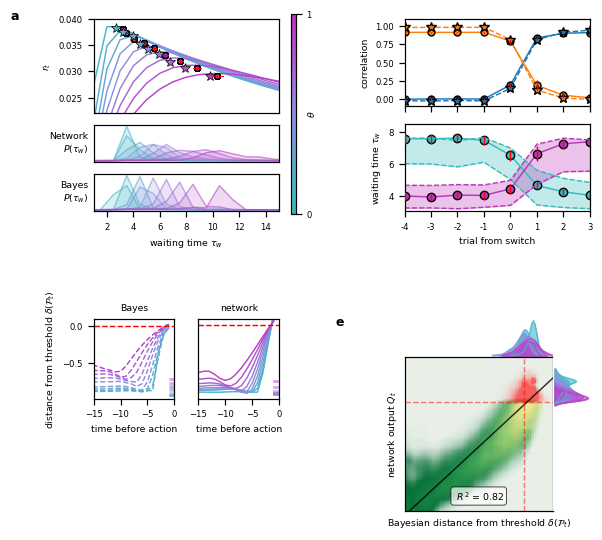

In [18]:
# final touches
from matplotlib.transforms import blended_transform_factory
from enzyme.plot_helper import add_panel_label, xylabel_to_ticks
fig.set_layout_engine('none')

# add cax to the right of fig
cax = subfigs[0,0].add_axes([.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax, label=r"$\theta$",)
cax = cbar.ax
cax.set_yticks([0, 1])
cax.set_yticklabels([0, 1])
xylabel_to_ticks(cax, which='right')

for k, ax in axd.items():
    if k not in 'abcde':
        continue

    if k in 'ac':
        transform = blended_transform_factory(axd['a'].transAxes, ax.transAxes)  # fix vertical
    elif k in 'ab':
        transform = blended_transform_factory(ax.transAxes, axd['a'].transAxes)  # fix horizontal
    else:
        transform = blended_transform_factory(ax.transAxes, ax.transAxes)
    
    add_panel_label(ax, k, x=-0.4, y=1.1, transform=transform)

# fig.legend(handles, labels, loc="outside upper center", ncol=4, frameon=False, handlelength=4)
fig

In [19]:
notebook_name = str(Path(globals()['__vsc_ipynb_file__']).stem).replace('_batch', '')

out_name = f'{notebook_name}.svg'
# use_skunk = True
# if use_skunk:
#     import skunk
#     svg_to_place = FIGPATH / 'mechanistic_model.svg'
#     skunk.connect(axd['d1'], 'A')
#     svg = skunk.insert({'A': str(svg_to_place)})

#     # write to file
#     with open(FIGPATH / out_name, 'w') as f:
#         f.write(svg)
#     # or in jupyter notebook
#     skunk.display(svg)

save_plot(f"_{notebook_name}", fig=fig, 
          path=FIGPATH,
          file_formats=[
    "svg", 
    "png", 
    "pdf"
]
, bbox_inches='tight')

In [20]:
"""
net, _, _ = batch_to_MU_STD(plotting_data, "QDIFF_mu_last_nog", "trained_LSTM", batch_num)
bayes, _, _ = batch_to_MU_STD(plotting_data, "DV_mu_last_nog", "trained_LSTM", batch_num)
fig,ax = plt.subplots(1,2, figsize = (10, 5))
T = 13
xax = np.arange(T)
s = len(net[0])//2
for ip, p in enumerate(PGO_show):
    ax[0].axhline(net[ip, s], linestyle= '-', linewidth = 3, color=cmap_cool(p), alpha = .25)
    ax[0].plot(xax, net[ip, s:s+T], '-', color=cmap_cool(p), label=rf"$\theta$ = {p:.1f}")
ax[0].set_xlabel("time from last nogo")
ax[0].set_title(r"network $\Delta$Q")

for ip, p in enumerate(PGO_show):
    ax[1].axhline(bayes[ip, s], linestyle= '--', linewidth = 3, color=cmap_cool(p), alpha = .25)
    ax[1].plot(xax, bayes[ip, s:s+T], '--', color=cmap_cool(p), label=rf"$\theta$ = {p:.1f}")
ax[1].set_xlabel("time from last nogo")
ax[1].set_title("Bayes DV")
plt.show()
"""

'\nnet, _, _ = batch_to_MU_STD(plotting_data, "QDIFF_mu_last_nog", "trained_LSTM", batch_num)\nbayes, _, _ = batch_to_MU_STD(plotting_data, "DV_mu_last_nog", "trained_LSTM", batch_num)\nfig,ax = plt.subplots(1,2, figsize = (10, 5))\nT = 13\nxax = np.arange(T)\ns = len(net[0])//2\nfor ip, p in enumerate(PGO_show):\n    ax[0].axhline(net[ip, s], linestyle= \'-\', linewidth = 3, color=cmap_cool(p), alpha = .25)\n    ax[0].plot(xax, net[ip, s:s+T], \'-\', color=cmap_cool(p), label=rf"$\theta$ = {p:.1f}")\nax[0].set_xlabel("time from last nogo")\nax[0].set_title(r"network $\\Delta$Q")\n\nfor ip, p in enumerate(PGO_show):\n    ax[1].axhline(bayes[ip, s], linestyle= \'--\', linewidth = 3, color=cmap_cool(p), alpha = .25)\n    ax[1].plot(xax, bayes[ip, s:s+T], \'--\', color=cmap_cool(p), label=rf"$\theta$ = {p:.1f}")\nax[1].set_xlabel("time from last nogo")\nax[1].set_title("Bayes DV")\nplt.show()\n'

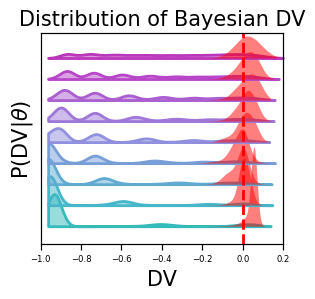

In [21]:
all_kdes = []
act_kdes = []
pre_kdes = []

# Collect KDE data
for p_i, PGO in enumerate(PGO_show):
    all_kdes.append(bayes_DV_all[PGO_flat == PGO])
    pre_kdes.append(bayes_DV_pre_act[bayes_pre_act_PGO == PGO])
    act_kdes.append(bayes_DV_at_act[bayes_at_act_PGO == PGO])

fig, ax = plt.subplots(figsize=(3, 3))

# Plot distributions with vertical offsets
for i, PGO in enumerate(PGO_show):
    # Vertical offset for this group
    y_offset = 6*i

    # Plot all_kdes with vertical shift
    sns.kdeplot(
        all_kdes[i], 
        ax=ax, 
        color=PGO_col[i], 
        alpha=0.5, 
        fill=True, 
        bw_adjust=2,
        linewidth=2,
        cut = 0,
        clip_on=False
    )
    
    # Manually adjust y-coordinates for the KDE
    all_path = ax.collections[-1].get_paths()[-1]
    all_path.vertices[:, 1] += y_offset

    # Plot act_kdes with vertical shift
    sns.kdeplot(
        act_kdes[i],
        ax=ax,
        color="r",
        alpha=.5,
        fill=True,
        bw_adjust=5,
        linewidth=0,
        cut = 0,
        )
    
    # Manually adjust y-coordinates for the KDE
    act_path = ax.collections[-1].get_paths()[-1]
    act_path.vertices[:, 1] += y_offset

# Adjust axis limits and labels
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title("Distribution of Bayesian DV", fontsize=15)
ax.set_xlabel("DV", fontsize=15)
ax.set_ylabel(r"P(DV|$\theta$)", fontsize=15)
ax.axvline(x=0, linestyle="--", c="r", linewidth = 2)
ax.set_ylim([-5, 55])
# Final layout and save
ax.set_xlim(-1, .2)
plt.tight_layout()
plt.savefig(str(FIGPATH) + "/bayes_DV_at_network_action_horizontal.svg")
plt.show()


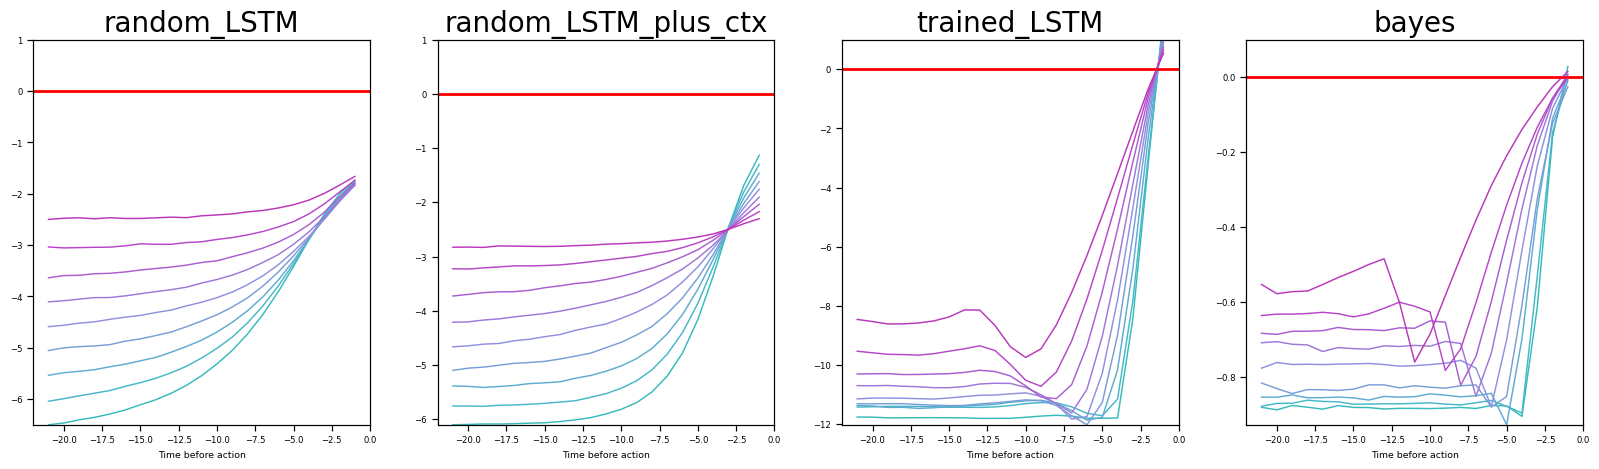

In [22]:
T = len(flow_dist_from_opt_mus[0])//2 + 1
xax = np.arange(-T, 0)

fig,ax = plt.subplots(1, 4, figsize = (20, 5))

i = 0

agent = "random_LSTM"
net_dist_from_opt_mus, _, _ = batch_to_MU_STD(plotting_data, "QDIFF_mu", agent, batch_num)

for i, (agent, ymax) in enumerate(zip(["random_LSTM", "random_LSTM_plus_ctx", "trained_LSTM", "bayes"], [1, 1, 1, .1])):
    if agent == "bayes":
        dist_from_opt = plotting_data["bayes_agent_and_trained_LSTM_representation"]["bayes_DV_mu"]

    else:
        dist_from_opt, _, _ = batch_to_MU_STD(plotting_data, "QDIFF_mu", agent, batch_num)

    for p in range(PGO_N):
        ax[i].plot(xax, dist_from_opt[p,:T], c = PGO_col[p])
        ax[i].axhline(0, c='r')
    ax[i].set_title(agent, fontsize = 20)
    ax[i].set_xlabel(r"Time before action")
    ax[i].set_ylim([dist_from_opt.min(), ymax])

plt.show()
